# Import Library

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline

from keras.applications import MobileNet
from keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from keras.layers import InputLayer



Using TensorFlow backend.


# Define Constants

In [3]:
FAST_RUN = True
IMAGE_WIDTH=200
IMAGE_HEIGHT=200
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [3]:
df=pd.read_csv('labels.csv')
a=df.to_numpy()
a[1][0]

1

In [4]:
filenames = os.listdir("./train")
categories = []
i=0
for filename in filenames:
    category = filename.split('.')[0]
    if a[i][1]==1:
        categories.append(1)
    else:
        categories.append(0)
    i=i+1

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.shape

(200, 2)

In [6]:
df.head(10)

,filename,category
0,000.png,1
1,001.png,1
2,002.png,1
3,003.png,1
4,004.png,1
5,005.png,1
6,006.png,1
7,007.png,1
8,008.png,1
9,009.png,1


In [7]:
df.tail()

,filename,category
195,195.png,0
196,196.png,0
197,197.png,0
198,198.png,0
199,199.png,0


### See Total In count

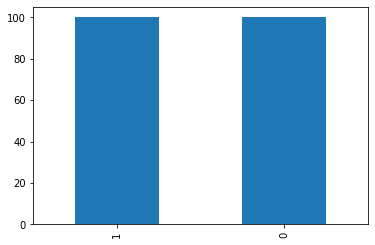

In [8]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

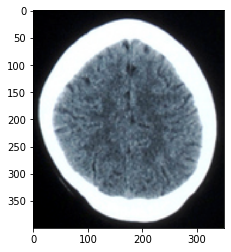

In [9]:
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image)
# plt.show()

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

# Callbacks

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
earlystop = EarlyStopping(patience=3)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

In [15]:
df["category"] = df["category"].replace({0: 'Nothing', 1: 'Screwed'}) 

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

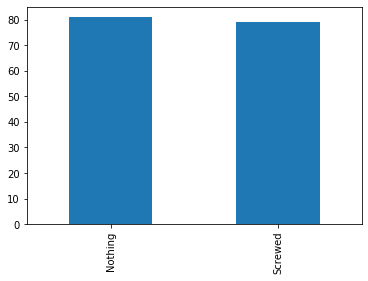

In [17]:
train_df['category'].value_counts().plot.bar()

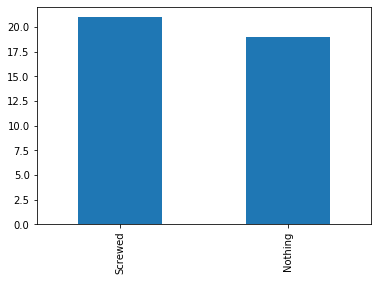

In [18]:
a = validate_df['category'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

print(total_train)
print(total_validate)

160
40


# Traning Generator

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=90,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=15
)

Found 160 validated image filenames belonging to 2 classes.


### Validation Generator

In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 40 validated image filenames belonging to 2 classes.


In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


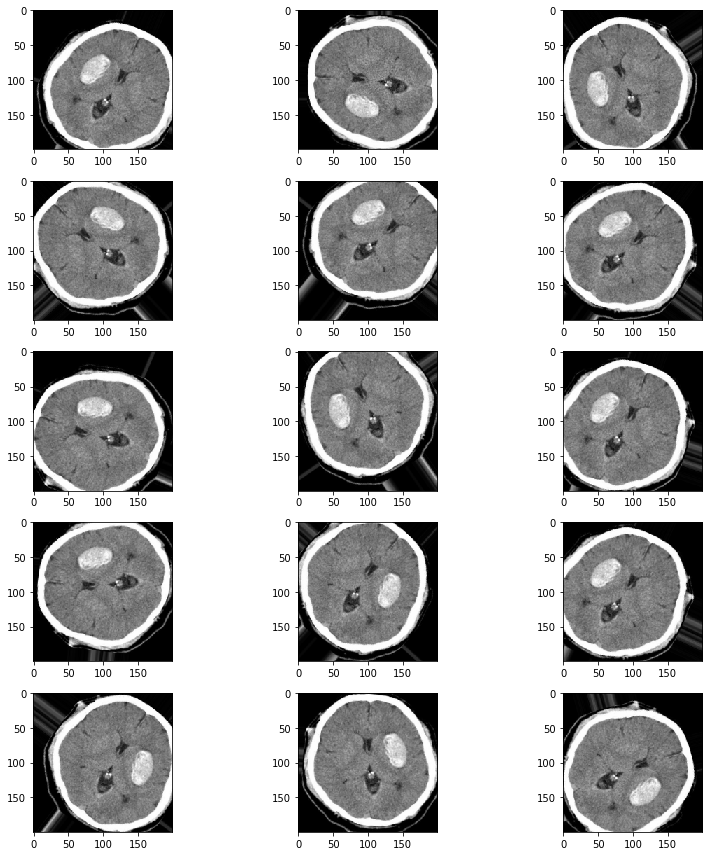

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [32]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Conv2D(32, kernel_size=(7, 7),
                 activation='relu',
                 input_shape=(200,200,3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
# 64 3x3 kernels
model.add(Conv2D(128, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(BatchNormalization())

model.add(Conv2D(128, (4, 4), activation='relu'))
# Reduce by taking the max of each 2x2 block


# model.add(Conv2D(256, (4, 4), activation='relu'))
# model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(BatchNormalization())

# model.add(Conv2D(512, (2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=(8, 8)))
# model.add(BatchNormalization())

# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
#model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd()',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 194, 194, 32)      4736      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 59, 59, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 128)      

In [35]:
epochs=20 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    verbose=2,
   
)

Epoch 1/20
Epoch 1/20
10/10 - 2s - loss: 0.3500 - acc: 0.8345 - val_loss: 0.4069 - val_acc: 0.8667
Epoch 2/20
Epoch 1/20
10/10 - 2s - loss: 0.3963 - acc: 0.8000 - val_loss: 0.6204 - val_acc: 0.8667
Epoch 3/20
Epoch 1/20
10/10 - 2s - loss: 0.3636 - acc: 0.8828 - val_loss: 0.9187 - val_acc: 0.8667
Epoch 4/20
Epoch 1/20
10/10 - 2s - loss: 0.4937 - acc: 0.7586 - val_loss: 0.9265 - val_acc: 0.8000
Epoch 5/20
Epoch 1/20
10/10 - 2s - loss: 0.3407 - acc: 0.8467 - val_loss: 0.9702 - val_acc: 0.8000
Epoch 6/20
Epoch 1/20
10/10 - 2s - loss: 0.3084 - acc: 0.8759 - val_loss: 0.3879 - val_acc: 0.8333
Epoch 7/20
Epoch 1/20
10/10 - 2s - loss: 0.3838 - acc: 0.8483 - val_loss: 0.7399 - val_acc: 0.8000
Epoch 8/20
Epoch 1/20
10/10 - 2s - loss: 0.4684 - acc: 0.8276 - val_loss: 0.6451 - val_acc: 0.8000
Epoch 9/20
Epoch 1/20
10/10 - 2s - loss: 0.3326 - acc: 0.8414 - val_loss: 0.4594 - val_acc: 0.8000
Epoch 10/20
Epoch 1/20
10/10 - 2s - loss: 0.3714 - acc: 0.8345 - val_loss: 0.6719 - val_acc: 0.8333
Epoch 11/

In [36]:
model.save_weights("modelbest14.h5")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [ ]:
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

# Predict

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()